In [1]:
import pandas as pd
import numpy as np

In [2]:
df_carprice=pd.read_csv('data.txt')
df_carprice.head(2)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650


In [3]:
df_carprice = df_carprice[[
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]]

In [4]:
df_carprice.columns = df_carprice.columns.str.replace(' ', '_').str.lower()

In [5]:
df_carprice.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [6]:
df_carprice=df_carprice.fillna(0)
df_carprice.isnull().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [7]:
def above_average(row):
    if row['msrp'] > mean_price:
        return 1
    else:
        return 0

In [8]:
mean_price=df_carprice['msrp'].mean()
df_carprice['above_average'] = df_carprice.apply(above_average, axis=1)

df_carprice.groupby(['above_average']).agg({'above_average':'count'})

,above_average
above_average,
0,8645
1,3269


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_full_train, df_test = train_test_split(df_carprice, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:
print(len(df_train), len(df_test), len(df_val))

7148 2383 2383


In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

## Question 1: ROC AUC feature importance

In [13]:
df_carprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11914 non-null  float64
 4   engine_cylinders   11914 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   msrp               11914 non-null  int64  
 10  above_average      11914 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1024.0+ KB


In [14]:
categorical=['make', 'model', 'transmission_type', 'vehicle_style']
numerical=['year','engine_hp', 'engine_cylinders', 'highway_mpg','city_mpg']

In [15]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [17]:
y_pred = model.predict_proba(X_val)[:, 1]

In [18]:
from sklearn.metrics import roc_auc_score

In [19]:
roc_auc_score(y_val, y_pred)

0.9796270846488133

In [20]:
def calc_score(categorical, numerical):
    dv = DictVectorizer(sparse=False)

    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]

    return roc_auc_score(y_val, y_pred)

In [21]:
categorical=['make', 'model', 'transmission_type', 'vehicle_style']
# numerical=['year','engine_hp', 'engine_cylinders', 'highway_mpg','city_mpg']
numerical=['year']

calc_score(categorical, numerical)

0.9697744714644763

In [22]:
categorical=['make', 'model', 'transmission_type', 'vehicle_style']
# numerical=['year','engine_hp', 'engine_cylinders', 'highway_mpg','city_mpg']
numerical=['engine_hp']

calc_score(categorical, numerical)

0.9849075759264075

In [23]:
categorical=['make', 'model', 'transmission_type', 'vehicle_style']
# numerical=['year','engine_hp', 'engine_cylinders', 'highway_mpg','city_mpg']
numerical=['engine_cylinders']

calc_score(categorical, numerical)

0.9829558016424265

In [24]:
categorical=['make', 'model', 'transmission_type', 'vehicle_style']
# numerical=['year','engine_hp', 'engine_cylinders', 'highway_mpg','city_mpg']
numerical=['highway_mpg']

calc_score(categorical, numerical)

0.981094673875939

In [25]:
categorical=['make', 'model', 'transmission_type', 'vehicle_style']
# numerical=['year','engine_hp', 'engine_cylinders', 'highway_mpg','city_mpg']
numerical=['city_mpg']

calc_score(categorical, numerical)

0.980020181010041

## Answer for Q1: engine_hp

## Question 2: Training the model

In [26]:
dv = DictVectorizer(sparse=False)

# train_dict = df_train[categorical + numerical].to_dict(orient='records')
# X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_val, y_val)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred)

0.9908137492637734

## Answer for Q1: 0.979?

## Question 3: Precision and Recall

In [27]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [28]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [29]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [30]:
p = tp / (tp + fp)
r = tp / (tp + fn)
print(p, r)

0.9157566302652106 0.8975535168195719


In [31]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    print(t, p, r)
        
    precisions.append(p)
    recalls.append(r)

0.0 0.27444397817876626 1.0
0.01 0.3722253841775754 1.0
0.02 0.4711815561959654 1.0
0.03 0.5409429280397022 1.0
0.04 0.6005509641873278 1.0
0.05 0.6349514563106796 1.0
0.06 0.6559679037111334 1.0
0.07 0.6653102746693794 1.0
0.08 0.6819603753910324 1.0
0.09 0.6884210526315789 1.0
0.1 0.692063492063492 1.0
0.11 0.7067099567099567 0.9984709480122325
0.12 0.7152245345016429 0.9984709480122325
0.13 0.7265625 0.9954128440366973
0.14 0.7453917050691244 0.9892966360856269
0.15 0.7511627906976744 0.9877675840978594
0.16 0.7561547479484173 0.9862385321100917
0.17 0.7684964200477327 0.9847094801223242
0.18 0.773109243697479 0.9847094801223242
0.19 0.7822384428223844 0.9831804281345565
0.2 0.8017565872020075 0.9770642201834863
0.21 0.8078381795195955 0.9770642201834863
0.22 0.8177150192554558 0.9740061162079511
0.23 0.8206451612903226 0.9724770642201835
0.24 0.8268229166666666 0.9709480122324159
0.25 0.8335535006605019 0.9648318042813455
0.26 0.8344370860927153 0.963302752293578
0.27 0.84295302013

C:\Users\Pedro.dias\AppData\Local\Temp\ipykernel_19364\2765712275.py:15: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


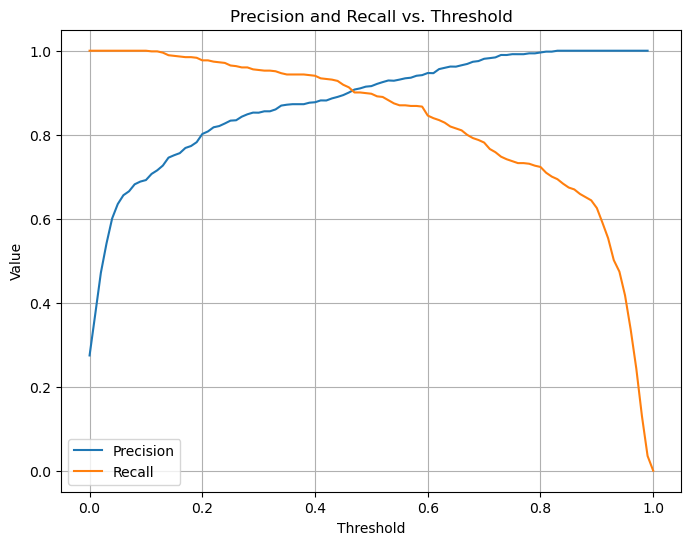

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision', marker='')
plt.plot(thresholds, recalls, label='Recall', marker='')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

## Answer for Q3: 0.48

## Question 4: F1 score

In [35]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []
f1s = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * ((p*r)/(p+r))
        
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

C:\Users\Pedro.dias\AppData\Local\Temp\ipykernel_19364\4146906372.py:16: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


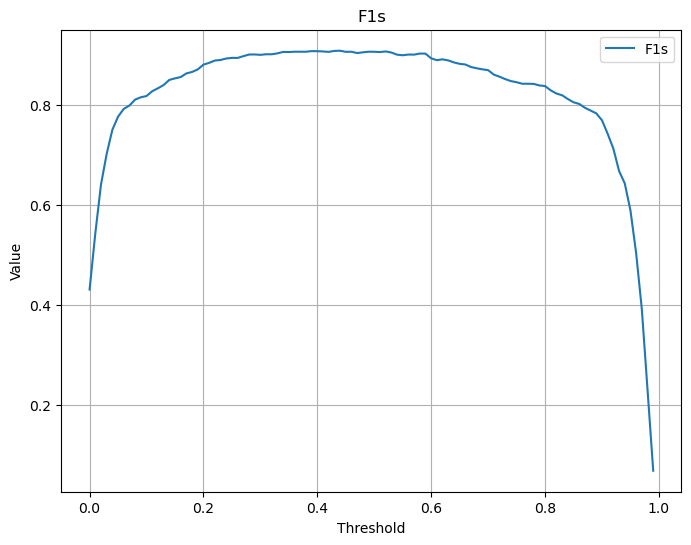

In [38]:
# import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1s, label='F1s', marker='')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('F1s')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
max_value=max(f1s)
f1s.index(max_value)

44

In [45]:
thresholds[f1s.index(max_value)]

0.44

## Answer for Q4: 0.44??

## Question 5: 5-Fold CV

In [47]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [51]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [52]:
dv, model = train(df_train, y_train, C=0.001)

In [53]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [54]:
y_pred = predict(df_val, dv, model)

In [56]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print((np.mean(scores), np.std(scores)))

(0.9753278931365623, 0.0039658795845277876)


## Answer for Q5 is 0.004

## Question 6: Hyperparemeter Tuning

In [57]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.906 +- 0.008
C=0.1 0.946 +- 0.007
C=0.5 0.969 +- 0.005
C=10 0.982 +- 0.002


## Answer for Q6: C=10